In [21]:
from pathlib import Path
import glob
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker
import matplotlib.cm as cm
from matplotlib.lines import Line2D

import scienceplots


SINGLE_COL_WIDTH = 3.5
DOUBLE_COL_WIDTH = 7.16
DPI = 150

plt.style.use(["science", "ieee"])
plt.rcParams.update({
    "mathtext.fontset": "cm",
    "text.usetex": False,
})

ref_style = {
    "linestyle": "--",
    "color": "black",
    "alpha": 0.7,
    "linewidth": 1.0,
    "label": "ED Reference",
}

# use the color palette manually, since importing seaborn overrides the paper styles
SB_COLORBLIND = [
    "#0173b2",
    "#de8f05",
    "#029e73",
    "#d55e00",
    "#cc78bc",
    "#ca9161",
    "#fbafe4",
    "#949494",
    "#ece133",
    "#56b4e9",
]

main_style = {
    "linestyle": "-",
    "linewidth": 1.0,
    "alpha": 0.9,
    "marker": "o",
    "markersize": 3,
    "markeredgewidth": 0.0,
    "color": SB_COLORBLIND[0],
}

SUPPORT_GUIDE_LS = (0, (1.5, 2.8))  # a bit finer than (2,2)
SUPPORT_GUIDE_LW = 0.75            # thinner
SUPPORT_GUIDE_A  = 0.30            # more transparent
SUPPORT_GUIDE_C  = "0.20"          # slightly lighter gray
SUPPORT_LABEL_A  = 1.0
SUPPORT_LABEL_T = r"Support $g$"

print("Global styles defined.")

Global styles defined.


In [22]:
# --- Data Config ---
CHAIN_LENGTH = 16
DATA_FILE = Path("tfim_l16_entangle_rbm_20251212_030007.csv")
REF_FILE = Path(f"tfim_{CHAIN_LENGTH}_entropy_ref.csv")

# --- Load & Process ---
if DATA_FILE.exists():
    df_res = pd.read_csv(DATA_FILE)
    ref_df_2 = pd.read_csv(REF_FILE) if REF_FILE.exists() else pd.DataFrame()

    # Pivot for 3D Surface
    pivot_df = df_res.pivot(index="l", columns="h", values="s2")

    # Meshgrid Construction
    h_dense = pivot_df.columns.values.astype(float)
    l_values = pivot_df.index.values.astype(int)
    X_h, Y_l = np.meshgrid(h_dense, l_values)
    Z_s2 = pivot_df.values

    # Find support cuts
    support_h_keys = np.sort(
        df_res[df_res["type"] == "support"]["h"].unique()
    )

    if not ref_df_2.empty:
        ref_df_2["h"] = ref_df_2["h"].astype(float)

    print(f"Data Loaded. Cuts at h={support_h_keys}")
else:
    print("Error: Main data file not found.")
    df_res, pivot_df, X_h, Y_l, Z_s2, support_h_keys = None, None, None, None, None, []
    ref_df_2 = pd.DataFrame()

Data Loaded. Cuts at h=[0.5  0.8  0.95 1.   1.05 1.2  1.5 ]


Saved: tfim_4x4_entropy_2d.pdf


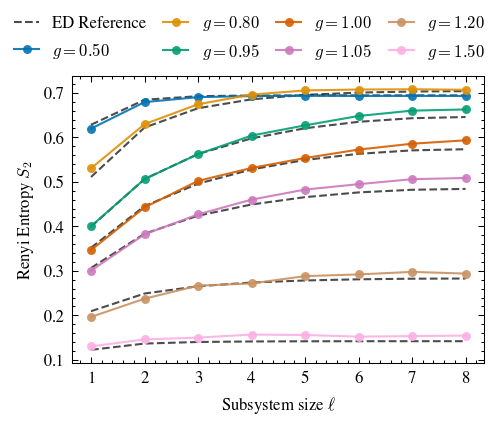

In [23]:
# =========================
# Cell - Entropy cuts (2D only)  [style-aligned with overlap-vs-g]
# =========================
SAVE_FIG = True
FILENAME = "tfim_4x4_entropy_2d.pdf"
COLUMN_MODE = "single"
FIELD_SYMBOL = "g"  # display-only (data column stays "h")

# figure size (same convention as overlap-vs-g)
FIG_HEIGHT_RATIO = 0.85
width  = SINGLE_COL_WIDTH if COLUMN_MODE == "single" else DOUBLE_COL_WIDTH
height = width * FIG_HEIGHT_RATIO

# legend placement knobs
LEGEND_ANCHOR_X = 0.43
LEGEND_ANCHOR_Y = 1.03
LEGEND_NCOL     = 4
LEGEND_LOC      = "lower center"

# --- markers: FULL (filled), overlap-vs-g style ---
MARKER_SHAPE = "o"
MARKER_SIZE  = 4.3   # <- was 4.6
MARKER_EDGEW = 0.0

# --- line style (same sources as overlap-vs-g) ---
LINESTYLE = main_style.get("linestyle", "-")
LINEWIDTH = main_style.get("linewidth", 1.0)
LINEALPHA = main_style.get("alpha", 0.9)  # keep your global main_style (0.9)

fig, ax = plt.subplots(figsize=(width, height), dpi=DPI)

# colors picked in order of h (sorted)
h_sorted = sorted([float(h) for h in support_h_keys])
colors   = SB_COLORBLIND
h_to_color = {h0: colors[i % len(colors)] for i, h0 in enumerate(h_sorted)}

ref_label_added = False

for h0 in h_sorted:
    subset = df_res[df_res["h"] == h0].sort_values("l")
    ell = subset["l"].values
    s2  = subset["s2"].values
    color = h_to_color[h0]

    # ED reference curve (if available)
    if (ref_df_2 is not None) and (not ref_df_2.empty):
        mask = np.isclose(ref_df_2["h"].values, h0, atol=1e-6)
        if mask.any():
            row = ref_df_2.loc[mask].iloc[0]

            x_ref, y_ref = [], []
            for c in ref_df_2.columns:
                if c.startswith("l"):
                    x_ref.append(int(c[1:]))
                    y_ref.append(float(row[c]))

            if x_ref:
                x_ref = np.asarray(x_ref, dtype=int)
                y_ref = np.asarray(y_ref, dtype=float)
                order = np.argsort(x_ref)

                style_kwargs = ref_style.copy()
                style_kwargs["label"] = style_kwargs["label"] if not ref_label_added else "_nolegend_"
                ax.plot(x_ref[order], y_ref[order], **style_kwargs, zorder=2)
                ref_label_added = True

    # model curve (FILLED markers)
    ax.plot(
        ell, s2,
        color=color,
        label=rf"${FIELD_SYMBOL}={h0:.2f}$",
        linestyle=LINESTYLE,
        linewidth=LINEWIDTH,
        alpha=LINEALPHA,
        marker=MARKER_SHAPE,
        markersize=MARKER_SIZE,
        fillstyle="full",
        markerfacecolor=color,
        markeredgecolor=color,
        markeredgewidth=MARKER_EDGEW,
        zorder=3,
    )

ax.set_xlabel(r"Subsystem size $\ell$")
ax.set_ylabel(r"Renyi Entropy $S_2$")

# integer ticks on ℓ
ax.xaxis.set_major_locator(mticker.MultipleLocator(1))

ax.grid(False)

leg = ax.legend(
    frameon=False,
    ncol=LEGEND_NCOL,
    loc=LEGEND_LOC,
    bbox_to_anchor=(LEGEND_ANCHOR_X, LEGEND_ANCHOR_Y),
    columnspacing=1.0,
    handlelength=1.5,
    borderaxespad=0.0,
)

fig.tight_layout()

if SAVE_FIG:
    fig.savefig(FILENAME, bbox_inches="tight", bbox_extra_artists=[leg])
    print(f"Saved: {FILENAME}")

plt.show()

Saved: tfim_4x4_entropy_3d.pdf


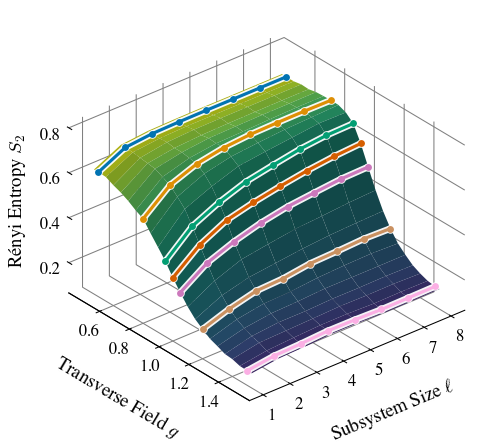

In [34]:
# =========================
# Cell - Entropy surface (3D only)  [viridis surface + cut lines WITH markers]
# (manual crop viewport + visible crop box + optional axes scaling)
# =========================
from matplotlib.transforms import Bbox
from matplotlib.patches import Rectangle

SAVE_FIG = True
FILENAME = "tfim_4x4_entropy_3d.pdf"
COLUMN_MODE = "single"

# ==========================================================
# FONT SIZES (separate knobs)
# ==========================================================
TEXT_SIZE = 9
TICK_LABEL_SIZE = 8
LEGEND_SIZE = 8
PANE_LABEL_SIZE = 12  # (kept for compatibility; no panel indices)

# ==========================================================
# 3D KNOBS (kept)
# ==========================================================
SHIFT_3D_X = -0.02

BOX_ASPECT_X = 1.0
BOX_ASPECT_Y = 1.0
BOX_ASPECT_Z = 0.7

XTICK_PAD = -3
YTICK_PAD = -3
ZTICK_PAD = -3

X_LABEL_SPACE = 0.0
Y_LABEL_SPACE = 0.0
X_LABELPAD = 0
Y_LABELPAD = 0

ZLABEL_X = -0.04
ZLABEL_Y = 0.55
ZLABEL_ROT = 90

VIEW_ELEV = 30
VIEW_AZIM = -40

# overlays
H_RIBBON_PAD = 0.02
CUT_WHITE_LW = 3.2
CUT_COLOR_LW = 1.5

# --- CUT LINE STYLE + DOTS (markers) ---
CUT_LINE_LS       = "-"
CUT_MARKER        = "o"
CUT_MARKER_SIZE   = 3.3
CUT_MARKER_EDGEW  = 0.0
CUT_MARKER_EVERY  = 1

# --- tiny surface tail in h-direction (constant extension) ---
H_SURFACE_TAIL = 0.03

# ==========================================================
# FIGURE SIZE
# ==========================================================
FIG_HEIGHT_RATIO_3D = 1.15
width  = SINGLE_COL_WIDTH if COLUMN_MODE == "single" else DOUBLE_COL_WIDTH
height = width * FIG_HEIGHT_RATIO_3D

FIELD_SYMBOL = "g"

def _apply_3d_label_spacing(ax, x_space, y_space, x_pad, y_pad):
    ax.xaxis._axinfo["label"]["space_factor"] = x_space
    ax.yaxis._axinfo["label"]["space_factor"] = y_space
    ax.xaxis.labelpad = x_pad
    ax.yaxis.labelpad = y_pad

# ==========================================================
# OPTIONAL: scale the *axes box* (keeps relative label geometry)
# ==========================================================
AXES_SCALE_X = 1.00   # >1 enlarges the 3D panel
AXES_SCALE_Y = 1.00
AXES_SHIFT_X = 0.00   # shift in figure fraction (+right, -left)
AXES_SHIFT_Y = 0.00   # (+up, -down)

# ==========================================================
# MANUAL CROP VIEWPORT (this is your "bounding box")
# ==========================================================
APPLY_CROP = True
SHOW_CROP_BOX = False

# crop amounts as fractions of the *figure*
CROP_LEFT_FRAC   = 0.05
CROP_RIGHT_FRAC  = 0.04
CROP_BOTTOM_FRAC = 0.15
CROP_TOP_FRAC    = 0.14   # <- "cut off a tiny bit of the top"

# shift + scale the crop box itself (in figure fraction)
CROP_SHIFT_X = 0.00
CROP_SHIFT_Y = 0.00
CROP_SCALE_X = 1.00
CROP_SCALE_Y = 1.00

CROP_PAD_INCH = 0.00  # add padding back (in inches) if you ever clip

def _make_crop_bbox(fig):
    fw, fh = fig.get_size_inches()

    # base box in figure-fraction coords
    x0 = CROP_LEFT_FRAC
    y0 = CROP_BOTTOM_FRAC
    w0 = 1.0 - CROP_LEFT_FRAC - CROP_RIGHT_FRAC
    h0 = 1.0 - CROP_BOTTOM_FRAC - CROP_TOP_FRAC

    # scale about center + shift
    cx = x0 + 0.5 * w0 + CROP_SHIFT_X
    cy = y0 + 0.5 * h0 + CROP_SHIFT_Y
    w  = w0 * CROP_SCALE_X
    h  = h0 * CROP_SCALE_Y

    x0n = cx - 0.5 * w
    y0n = cy - 0.5 * h
    x1n = cx + 0.5 * w
    y1n = cy + 0.5 * h

    # clamp to [0,1]
    x0n = max(0.0, min(1.0, x0n))
    y0n = max(0.0, min(1.0, y0n))
    x1n = max(0.0, min(1.0, x1n))
    y1n = max(0.0, min(1.0, y1n))
    if x1n <= x0n: x1n = min(1.0, x0n + 1e-3)
    if y1n <= y0n: y1n = min(1.0, y0n + 1e-3)

    # convert to inches for savefig(bbox_inches=...)
    bbox_in = Bbox.from_extents(x0n * fw, y0n * fh, x1n * fw, y1n * fh)
    if CROP_PAD_INCH > 0:
        bbox_in = bbox_in.padded(CROP_PAD_INCH)

    return bbox_in, (x0n, y0n, x1n - x0n, y1n - y0n)

with plt.rc_context({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "axes.labelsize": TEXT_SIZE,
    "xtick.labelsize": TICK_LABEL_SIZE,
    "ytick.labelsize": TICK_LABEL_SIZE,
    "legend.fontsize": LEGEND_SIZE,
}):
    fig = plt.figure(figsize=(width, height), dpi=DPI)
    fig.subplots_adjust(left=0.16, right=0.98, top=0.98, bottom=0.08)

    ax3d = fig.add_subplot(111, projection="3d")
    ax3d.set_proj_type("ortho")

    # keep your horizontal shift
    pos = ax3d.get_position()
    ax3d.set_position([pos.x0 + SHIFT_3D_X, pos.y0, pos.width, pos.height])

    # optional: scale the axes box (no label hacks)
    if (AXES_SCALE_X != 1.0) or (AXES_SCALE_Y != 1.0) or (AXES_SHIFT_X != 0.0) or (AXES_SHIFT_Y != 0.0):
        pos = ax3d.get_position()
        cx, cy = pos.x0 + pos.width/2, pos.y0 + pos.height/2
        nw, nh = pos.width * AXES_SCALE_X, pos.height * AXES_SCALE_Y
        nx0 = cx - nw/2 + AXES_SHIFT_X
        ny0 = cy - nh/2 + AXES_SHIFT_Y
        ax3d.set_position([nx0, ny0, nw, nh])

    ax3d.zaxis._axinfo["juggled"] = (1, 0, 2)

    ax3d.minorticks_off()
    ax3d.xaxis.set_minor_locator(ticker.NullLocator())
    ax3d.yaxis.set_minor_locator(ticker.NullLocator())
    ax3d.zaxis.set_minor_locator(ticker.NullLocator())

    ax3d.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax3d.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax3d.zaxis.set_major_locator(ticker.MultipleLocator(0.2))

    ax3d.set_box_aspect((BOX_ASPECT_X, BOX_ASPECT_Y, BOX_ASPECT_Z))

    grid_style = {"color": "gray", "linewidth": 0.5, "alpha": 0.3}
    for axis in (ax3d.xaxis, ax3d.yaxis, ax3d.zaxis):
        axis._axinfo["grid"].update(grid_style)
        axis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # ---- surface + tail ----
    h_min, h_max = float(h_dense.min()), float(h_dense.max())
    h_dense_ext = np.concatenate([[h_min - H_SURFACE_TAIL], h_dense, [h_max + H_SURFACE_TAIL]])
    Z_s2_ext = np.concatenate([Z_s2[:, [0]], Z_s2, Z_s2[:, [-1]]], axis=1)
    X_h_ext, Y_l_ext = np.meshgrid(h_dense_ext, l_values)

    cmap_surface = plt.get_cmap("viridis")
    norm_h = mcolors.Normalize(vmin=h_dense_ext.min(), vmax=h_dense_ext.max())

    t = norm_h(X_h_ext)
    t = 1.0 - t
    t = 0.10 + 0.85 * t
    surface_colors = cmap_surface(t)

    ax3d.plot_surface(
        X_h_ext, Y_l_ext, Z_s2_ext,
        facecolors=surface_colors,
        rstride=1, cstride=1,
        shade=True, linewidth=0, alpha=1.0, antialiased=True
    )

    ax3d.set_zlim(np.min(Z_s2) - 0.05, np.max(Z_s2) + 0.1)

    ax3d.set_xlabel(rf"Transverse Field ${FIELD_SYMBOL}$", fontsize=TEXT_SIZE)
    ax3d.set_ylabel(r"Subsystem Size $\ell$", fontsize=TEXT_SIZE)

    ax3d.set_zlabel("")
    zlab = ax3d.text2D(
        ZLABEL_X, ZLABEL_Y, r"Rényi Entropy $S_2$",
        transform=ax3d.transAxes,
        rotation=ZLABEL_ROT, va="center", ha="right",
        fontsize=TEXT_SIZE,
        clip_on=False
    )

    ax3d.view_init(elev=VIEW_ELEV, azim=VIEW_AZIM)
    _apply_3d_label_spacing(ax3d, X_LABEL_SPACE, Y_LABEL_SPACE, X_LABELPAD, Y_LABELPAD)

    # ---- overlays ----
    h_sorted = sorted([float(h) for h in support_h_keys])
    h_to_color = {h0: SB_COLORBLIND[i % len(SB_COLORBLIND)] for i, h0 in enumerate(h_sorted)}

    for h0 in h_sorted:
        subset = df_res[df_res["h"] == h0].sort_values("l")
        ell = subset["l"].values.astype(int)
        s2_vals = subset["s2"].values.astype(float)
        color = h_to_color[h0]

        h_left, h_right = h0 - H_RIBBON_PAD, h0 + H_RIBBON_PAD
        X_rib = np.vstack([np.full_like(ell, h_left, float), np.full_like(ell, h_right, float)])
        Y_rib = np.vstack([ell, ell])
        Z_rib = np.vstack([s2_vals, s2_vals])

        ax3d.plot_surface(X_rib, Y_rib, Z_rib, color=color, shade=True, linewidth=0, alpha=1.0, antialiased=True)

        xline = np.full_like(ell, h0, dtype=float)

        ax3d.plot(
            xline, ell, s2_vals,
            color="white",
            linestyle=CUT_LINE_LS,
            linewidth=CUT_WHITE_LW,
            alpha=0.95,
            marker=CUT_MARKER,
            markersize=CUT_MARKER_SIZE + 0.8,
            markerfacecolor="white",
            markeredgecolor="white",
            markeredgewidth=0.0,
            markevery=CUT_MARKER_EVERY,
            solid_capstyle="round", solid_joinstyle="round",
            zorder=19,
        )
        ax3d.plot(
            xline, ell, s2_vals,
            color=color,
            linestyle=CUT_LINE_LS,
            linewidth=CUT_COLOR_LW,
            alpha=1.0,
            marker=CUT_MARKER,
            markersize=CUT_MARKER_SIZE,
            markerfacecolor=color,
            markeredgecolor=color,
            markeredgewidth=CUT_MARKER_EDGEW,
            markevery=CUT_MARKER_EVERY,
            solid_capstyle="round", solid_joinstyle="round",
            zorder=20,
        )

    # tick padding AFTER draw (kept)
    fig.canvas.draw()
    for tck in ax3d.xaxis.get_major_ticks(): tck.set_pad(XTICK_PAD)
    for tck in ax3d.yaxis.get_major_ticks(): tck.set_pad(YTICK_PAD)
    for tck in ax3d.zaxis.get_major_ticks(): tck.set_pad(ZTICK_PAD)

    for lab in ax3d.get_xticklabels() + ax3d.get_yticklabels() + ax3d.get_zticklabels():
        lab.set_clip_on(False)
        lab.set_fontsize(TICK_LABEL_SIZE)

    fig.canvas.draw()

    # ---- draw crop box (debug) ----
    crop_bbox_in, (rx, ry, rw, rh) = _make_crop_bbox(fig)
    if SHOW_CROP_BOX:
        fig.add_artist(Rectangle(
            (rx, ry), rw, rh,
            transform=fig.transFigure,
            fill=False,
            linewidth=1.0,
            linestyle=(0, (3, 3)),
            edgecolor="crimson",
            alpha=0.85,
            zorder=9999,
        ))

    if SAVE_FIG:
        if APPLY_CROP:
            fig.savefig(FILENAME, bbox_inches=crop_bbox_in, bbox_extra_artists=[zlab])
        else:
            fig.savefig(FILENAME)
        print(f"Saved: {FILENAME}")

    plt.show()


Saved: tfim_4x4_entropy_3d_hero.svg


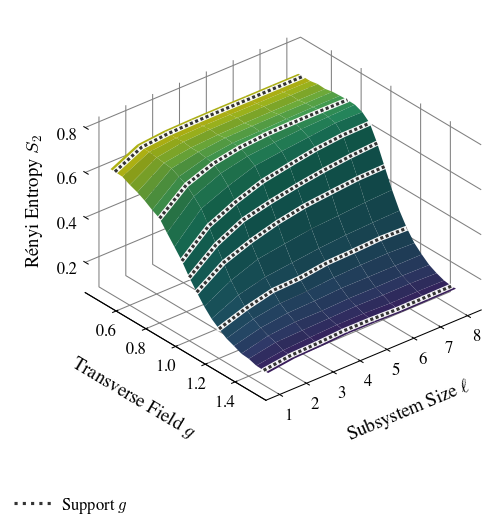

In [52]:
# =========================
# Cell - Entropy surface (3D only)  [viridis surface + cut lines]
# (manual crop viewport + visible crop box + optional axes scaling)
# =========================
from matplotlib.transforms import Bbox
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib import ticker
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

# Assumes external variables exist:
# df_res, h_dense, l_values, Z_s2, support_h_keys, ref_style, SB_COLORBLIND
# SINGLE_COL_WIDTH, DOUBLE_COL_WIDTH, DPI

SAVE_FIG = True
FILENAME = "tfim_4x4_entropy_3d_hero.svg"
COLUMN_MODE = "single"

# ==========================================================
# FONT SIZES (separate knobs)
# ==========================================================
TEXT_SIZE = 9
TICK_LABEL_SIZE = 8
LEGEND_SIZE = 8
PANE_LABEL_SIZE = 12

# ==========================================================
# 3D KNOBS
# ==========================================================
SHIFT_3D_X = -0.02

BOX_ASPECT_X = 1.0
BOX_ASPECT_Y = 1.0
BOX_ASPECT_Z = 0.7

XTICK_PAD = -3
YTICK_PAD = -3
ZTICK_PAD = -3

X_LABEL_SPACE = 0.0
Y_LABEL_SPACE = 0.0
X_LABELPAD = 0
Y_LABELPAD = 0

ZLABEL_X = -0.04
ZLABEL_Y = 0.55
ZLABEL_ROT = 90

VIEW_ELEV = 30
VIEW_AZIM = -40

# overlays
CUT_WHITE_LW = 2.5

# --- tiny surface tail in h-direction (constant extension) ---
H_SURFACE_TAIL = 0.03

# ==========================================================
# FIGURE SIZE
# ==========================================================
FIG_HEIGHT_RATIO_3D = 1.15
width  = SINGLE_COL_WIDTH if COLUMN_MODE == "single" else DOUBLE_COL_WIDTH
height = width * FIG_HEIGHT_RATIO_3D

FIELD_SYMBOL = "g"

def _apply_3d_label_spacing(ax, x_space, y_space, x_pad, y_pad):
    ax.xaxis._axinfo["label"]["space_factor"] = x_space
    ax.yaxis._axinfo["label"]["space_factor"] = y_space
    ax.xaxis.labelpad = x_pad
    ax.yaxis.labelpad = y_pad

# ==========================================================
# OPTIONAL: scale the *axes box*
# ==========================================================
AXES_SCALE_X = 1.00
AXES_SCALE_Y = 1.00
AXES_SHIFT_X = 0.00
AXES_SHIFT_Y = 0.00

# ==========================================================
# MANUAL CROP VIEWPORT
# ==========================================================
APPLY_CROP = True
SHOW_CROP_BOX = False

# crop amounts as fractions of the *figure*
CROP_LEFT_FRAC   = -0.05
CROP_RIGHT_FRAC  = 0.04
CROP_BOTTOM_FRAC = -0.2
CROP_TOP_FRAC    = 0.14

# shift + scale the crop box itself
CROP_SHIFT_X = 0.00
CROP_SHIFT_Y = 0.00
CROP_SCALE_X = 1.00
CROP_SCALE_Y = 1.00

CROP_PAD_INCH = 0.00

def _make_crop_bbox(fig):
    fw, fh = fig.get_size_inches()

    x0 = CROP_LEFT_FRAC
    y0 = CROP_BOTTOM_FRAC
    w0 = 1.0 - CROP_LEFT_FRAC - CROP_RIGHT_FRAC
    h0 = 1.0 - CROP_BOTTOM_FRAC - CROP_TOP_FRAC

    cx = x0 + 0.5 * w0 + CROP_SHIFT_X
    cy = y0 + 0.5 * h0 + CROP_SHIFT_Y
    w  = w0 * CROP_SCALE_X
    h  = h0 * CROP_SCALE_Y

    x0n = cx - 0.5 * w
    y0n = cy - 0.5 * h
    x1n = cx + 0.5 * w
    y1n = cy + 0.5 * h

    x0n = max(0.0, min(1.0, x0n))
    y0n = max(0.0, min(1.0, y0n))
    x1n = max(0.0, min(1.0, x1n))
    y1n = max(0.0, min(1.0, y1n))
    if x1n <= x0n: x1n = min(1.0, x0n + 1e-3)
    if y1n <= y0n: y1n = min(1.0, y0n + 1e-3)

    bbox_in = Bbox.from_extents(x0n * fw, y0n * fh, x1n * fw, y1n * fh)
    if CROP_PAD_INCH > 0:
        bbox_in = bbox_in.padded(CROP_PAD_INCH)

    return bbox_in, (x0n, y0n, x1n - x0n, y1n - y0n)

with plt.rc_context({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "savefig.transparent": False,
    "axes.labelsize": TEXT_SIZE,
    "xtick.labelsize": TICK_LABEL_SIZE,
    "ytick.labelsize": TICK_LABEL_SIZE,
    "legend.fontsize": LEGEND_SIZE,
}):
    fig = plt.figure(figsize=(width, height), dpi=DPI)
    fig.patch.set_alpha(1.0)
    fig.subplots_adjust(left=0.16, right=0.98, top=0.98, bottom=0.08)

    ax3d = fig.add_subplot(111, projection="3d")
    ax3d.set_proj_type("ortho")

    pos = ax3d.get_position()
    ax3d.set_position([pos.x0 + SHIFT_3D_X, pos.y0, pos.width, pos.height])

    # optional: scale the axes box
    if (AXES_SCALE_X != 1.0) or (AXES_SCALE_Y != 1.0) or (AXES_SHIFT_X != 0.0) or (AXES_SHIFT_Y != 0.0):
        pos = ax3d.get_position()
        cx, cy = pos.x0 + pos.width/2, pos.y0 + pos.height/2
        nw, nh = pos.width * AXES_SCALE_X, pos.height * AXES_SCALE_Y
        nx0 = cx - nw/2 + AXES_SHIFT_X
        ny0 = cy - nh/2 + AXES_SHIFT_Y
        ax3d.set_position([nx0, ny0, nw, nh])

    ax3d.zaxis._axinfo["juggled"] = (1, 0, 2)

    ax3d.minorticks_off()
    ax3d.xaxis.set_minor_locator(ticker.NullLocator())
    ax3d.yaxis.set_minor_locator(ticker.NullLocator())
    ax3d.zaxis.set_minor_locator(ticker.NullLocator())

    ax3d.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax3d.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax3d.zaxis.set_major_locator(ticker.MultipleLocator(0.2))

    ax3d.set_box_aspect((BOX_ASPECT_X, BOX_ASPECT_Y, BOX_ASPECT_Z))

    grid_style = {"color": "gray", "linewidth": 0.5, "alpha": 0.3}
    for axis in (ax3d.xaxis, ax3d.yaxis, ax3d.zaxis):
        axis._axinfo["grid"].update(grid_style)
        axis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # ==========================================================
    # SURFACE + TAIL (ONLY CHANGE)
    # ==========================================================
    h_min, h_max = float(h_dense.min()), float(h_dense.max())

    # extend x-grid, but replicate edge Z columns (so geometry continues smoothly)
    h_dense_ext = np.concatenate([[h_min - H_SURFACE_TAIL], h_dense, [h_max + H_SURFACE_TAIL]])
    Z_s2_ext = np.concatenate([Z_s2[:, [0]], Z_s2, Z_s2[:, [-1]]], axis=1)
    X_h_ext, Y_l_ext = np.meshgrid(h_dense_ext, l_values)

    cmap_surface = plt.get_cmap("viridis")

    # IMPORTANT: keep colormap normalization on ORIGINAL range,
    # and clip the tail to the edge colors (prevents “blue padding”).
    norm_h = mcolors.Normalize(vmin=h_min, vmax=h_max)
    X_for_color = np.clip(X_h_ext, h_min, h_max)

    t = norm_h(X_for_color)
    t = 1.0 - t
    t = 0.10 + 0.85 * t
    surface_colors = cmap_surface(t)

    ax3d.plot_surface(
        X_h_ext, Y_l_ext, Z_s2_ext,
        facecolors=surface_colors,
        rstride=1, cstride=1,
        shade=True, linewidth=0, alpha=1.0,
        antialiased=True
    )

    ax3d.set_zlim(np.min(Z_s2) - 0.05, np.max(Z_s2) + 0.1)

    ax3d.set_xlabel(rf"Transverse Field ${FIELD_SYMBOL}$", fontsize=TEXT_SIZE)
    ax3d.set_ylabel(r"Subsystem Size $\ell$", fontsize=TEXT_SIZE)

    ax3d.set_zlabel("")
    zlab = ax3d.text2D(
        ZLABEL_X, ZLABEL_Y, r"Rényi Entropy $S_2$",
        transform=ax3d.transAxes,
        rotation=ZLABEL_ROT, va="center", ha="right",
        fontsize=TEXT_SIZE,
        clip_on=False
    )

    ax3d.view_init(elev=VIEW_ELEV, azim=VIEW_AZIM)
    _apply_3d_label_spacing(ax3d, X_LABEL_SPACE, Y_LABEL_SPACE, X_LABELPAD, Y_LABELPAD)

    # ==========================================================
    # CUT LINES (NO RIBBONS)
    # ==========================================================
    h_sorted = sorted([float(h) for h in support_h_keys])

    _ref_dash = dict(ref_style)
    _ref_dash.pop("label", None)
    _ref_dash.pop("alpha", None)
    _ref_dash["linestyle"] = ":"
    _ref_dash["alpha"] = 1
    _ref_dash["color"] = "0.20"
    _ref_dash["linewidth"] = 1.5   # try 1.8–2.4
    _ref_dash["dashes"] = (1.0, 0.8)   # (on, off) in points



    # tiny lift to avoid z-fighting with the surface in SVG renderers
    Z_LIFT = 1e-4

    for h0 in h_sorted:
        subset = df_res[df_res["h"] == h0].sort_values("l")
        ell = subset["l"].values.astype(int)
        s2_vals = subset["s2"].values.astype(float) + Z_LIFT
        xline = np.full_like(ell, h0, dtype=float)

        ax3d.plot(
            xline, ell, s2_vals,
            color="white",
            linestyle="-",
            linewidth=CUT_WHITE_LW,
            alpha=0.95,
            zorder=19,
            solid_capstyle="round",
            solid_joinstyle="round",
        )

        ax3d.plot(
            xline, ell, s2_vals,
            **_ref_dash,
            zorder=20,
            solid_capstyle="round",
            solid_joinstyle="round",
        )

    # tick padding AFTER draw
    fig.canvas.draw()
    for tck in ax3d.xaxis.get_major_ticks(): tck.set_pad(XTICK_PAD)
    for tck in ax3d.yaxis.get_major_ticks(): tck.set_pad(YTICK_PAD)
    for tck in ax3d.zaxis.get_major_ticks(): tck.set_pad(ZTICK_PAD)

    for lab in ax3d.get_xticklabels() + ax3d.get_yticklabels() + ax3d.get_zticklabels():
        lab.set_clip_on(False)
        lab.set_fontsize(TICK_LABEL_SIZE)

    fig.canvas.draw()

    # legend handle
    support_handle = Line2D(
        [0], [0],
        linestyle=_ref_dash.get("linestyle", ":"),
        linewidth=_ref_dash.get("linewidth", 1.5),
        color=_ref_dash.get("color", "0.35"),
        alpha=_ref_dash.get("alpha", 1.0),
    )

    fig.legend(
        handles=[support_handle],
        labels=[r"Support $g$"],
        loc="lower left",
        bbox_to_anchor=(0.02, 0.02),
        frameon=False,
        handlelength=2.2,
        handletextpad=0.6,
    )

    # ---- draw crop box (debug) ----
    crop_bbox_in, (rx, ry, rw, rh) = _make_crop_bbox(fig)
    if SHOW_CROP_BOX:
        fig.add_artist(Rectangle(
            (rx, ry), rw, rh,
            transform=fig.transFigure,
            fill=False,
            linewidth=1.0,
            linestyle=(0, (3, 3)),
            edgecolor="crimson",
            alpha=0.85,
            zorder=9999,
        ))

    if SAVE_FIG:
        if APPLY_CROP:
            fig.savefig(
                FILENAME,
                bbox_inches=crop_bbox_in,
                bbox_extra_artists=[zlab],
                transparent=False,
                facecolor="white",
                edgecolor="none",
            )
        else:
            fig.savefig(
                FILENAME,
                transparent=False,
                facecolor="white",
                edgecolor="none",
            )
        print(f"Saved: {FILENAME}")

    plt.show()


Saved: tfim_4x4_entropy_3d_hero.svg


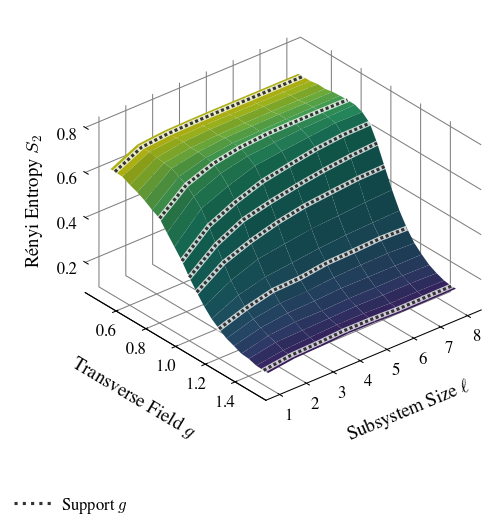

In [54]:
# =========================
# Cell - Entropy surface (3D only)  [viridis surface + cut lines]
# (manual crop viewport + visible crop box + optional axes scaling)
# =========================
from matplotlib.transforms import Bbox
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib import ticker
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

# Assumes external variables exist:
# df_res, h_dense, l_values, Z_s2, support_h_keys, ref_style, SB_COLORBLIND
# SINGLE_COL_WIDTH, DOUBLE_COL_WIDTH, DPI

SAVE_FIG = True
FILENAME = "tfim_4x4_entropy_3d_hero.svg"
COLUMN_MODE = "single"

# ==========================================================
# FONT SIZES (separate knobs)
# ==========================================================
TEXT_SIZE = 9
TICK_LABEL_SIZE = 8
LEGEND_SIZE = 8
PANE_LABEL_SIZE = 12

# ==========================================================
# 3D KNOBS
# ==========================================================
SHIFT_3D_X = -0.02

BOX_ASPECT_X = 1.0
BOX_ASPECT_Y = 1.0
BOX_ASPECT_Z = 0.7

XTICK_PAD = -3
YTICK_PAD = -3
ZTICK_PAD = -3

X_LABEL_SPACE = 0.0
Y_LABEL_SPACE = 0.0
X_LABELPAD = 0
Y_LABELPAD = 0

ZLABEL_X = -0.04
ZLABEL_Y = 0.55
ZLABEL_ROT = 90

VIEW_ELEV = 30
VIEW_AZIM = -40

# overlays
CUT_WHITE_LW    = 2.5
CUT_WHITE_ALPHA = 0.75   # 0.6–0.9

# --- tiny surface tail in h-direction (constant extension) ---
H_SURFACE_TAIL = 0.03

# ==========================================================
# FIGURE SIZE
# ==========================================================
FIG_HEIGHT_RATIO_3D = 1.15
width  = SINGLE_COL_WIDTH if COLUMN_MODE == "single" else DOUBLE_COL_WIDTH
height = width * FIG_HEIGHT_RATIO_3D

FIELD_SYMBOL = "g"

def _apply_3d_label_spacing(ax, x_space, y_space, x_pad, y_pad):
    ax.xaxis._axinfo["label"]["space_factor"] = x_space
    ax.yaxis._axinfo["label"]["space_factor"] = y_space
    ax.xaxis.labelpad = x_pad
    ax.yaxis.labelpad = y_pad

# ==========================================================
# OPTIONAL: scale the *axes box*
# ==========================================================
AXES_SCALE_X = 1.00
AXES_SCALE_Y = 1.00
AXES_SHIFT_X = 0.00
AXES_SHIFT_Y = 0.00

# ==========================================================
# MANUAL CROP VIEWPORT
# ==========================================================
APPLY_CROP = True
SHOW_CROP_BOX = False

# crop amounts as fractions of the *figure*
CROP_LEFT_FRAC   = -0.05
CROP_RIGHT_FRAC  = 0.04
CROP_BOTTOM_FRAC = -0.2
CROP_TOP_FRAC    = 0.14

# shift + scale the crop box itself
CROP_SHIFT_X = 0.00
CROP_SHIFT_Y = 0.00
CROP_SCALE_X = 1.00
CROP_SCALE_Y = 1.00

CROP_PAD_INCH = 0.00

def _make_crop_bbox(fig):
    fw, fh = fig.get_size_inches()

    x0 = CROP_LEFT_FRAC
    y0 = CROP_BOTTOM_FRAC
    w0 = 1.0 - CROP_LEFT_FRAC - CROP_RIGHT_FRAC
    h0 = 1.0 - CROP_BOTTOM_FRAC - CROP_TOP_FRAC

    cx = x0 + 0.5 * w0 + CROP_SHIFT_X
    cy = y0 + 0.5 * h0 + CROP_SHIFT_Y
    w  = w0 * CROP_SCALE_X
    h  = h0 * CROP_SCALE_Y

    x0n = cx - 0.5 * w
    y0n = cy - 0.5 * h
    x1n = cx + 0.5 * w
    y1n = cy + 0.5 * h

    x0n = max(0.0, min(1.0, x0n))
    y0n = max(0.0, min(1.0, y0n))
    x1n = max(0.0, min(1.0, x1n))
    y1n = max(0.0, min(1.0, y1n))
    if x1n <= x0n: x1n = min(1.0, x0n + 1e-3)
    if y1n <= y0n: y1n = min(1.0, y0n + 1e-3)

    bbox_in = Bbox.from_extents(x0n * fw, y0n * fh, x1n * fw, y1n * fh)
    if CROP_PAD_INCH > 0:
        bbox_in = bbox_in.padded(CROP_PAD_INCH)

    return bbox_in, (x0n, y0n, x1n - x0n, y1n - y0n)

with plt.rc_context({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "savefig.transparent": False,
    "axes.labelsize": TEXT_SIZE,
    "xtick.labelsize": TICK_LABEL_SIZE,
    "ytick.labelsize": TICK_LABEL_SIZE,
    "legend.fontsize": LEGEND_SIZE,
}):
    fig = plt.figure(figsize=(width, height), dpi=DPI)
    fig.patch.set_alpha(1.0)
    fig.subplots_adjust(left=0.16, right=0.98, top=0.98, bottom=0.08)

    ax3d = fig.add_subplot(111, projection="3d")
    ax3d.set_proj_type("ortho")

    pos = ax3d.get_position()
    ax3d.set_position([pos.x0 + SHIFT_3D_X, pos.y0, pos.width, pos.height])

    # optional: scale the axes box
    if (AXES_SCALE_X != 1.0) or (AXES_SCALE_Y != 1.0) or (AXES_SHIFT_X != 0.0) or (AXES_SHIFT_Y != 0.0):
        pos = ax3d.get_position()
        cx, cy = pos.x0 + pos.width/2, pos.y0 + pos.height/2
        nw, nh = pos.width * AXES_SCALE_X, pos.height * AXES_SCALE_Y
        nx0 = cx - nw/2 + AXES_SHIFT_X
        ny0 = cy - nh/2 + AXES_SHIFT_Y
        ax3d.set_position([nx0, ny0, nw, nh])

    ax3d.zaxis._axinfo["juggled"] = (1, 0, 2)

    ax3d.minorticks_off()
    ax3d.xaxis.set_minor_locator(ticker.NullLocator())
    ax3d.yaxis.set_minor_locator(ticker.NullLocator())
    ax3d.zaxis.set_minor_locator(ticker.NullLocator())

    ax3d.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax3d.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax3d.zaxis.set_major_locator(ticker.MultipleLocator(0.2))

    ax3d.set_box_aspect((BOX_ASPECT_X, BOX_ASPECT_Y, BOX_ASPECT_Z))

    grid_style = {"color": "gray", "linewidth": 0.5, "alpha": 0.3}
    for axis in (ax3d.xaxis, ax3d.yaxis, ax3d.zaxis):
        axis._axinfo["grid"].update(grid_style)
        axis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # ==========================================================
    # SURFACE + TAIL (ONLY CHANGE)
    # ==========================================================
    h_min, h_max = float(h_dense.min()), float(h_dense.max())

    # extend x-grid, but replicate edge Z columns (so geometry continues smoothly)
    h_dense_ext = np.concatenate([[h_min - H_SURFACE_TAIL], h_dense, [h_max + H_SURFACE_TAIL]])
    Z_s2_ext = np.concatenate([Z_s2[:, [0]], Z_s2, Z_s2[:, [-1]]], axis=1)
    X_h_ext, Y_l_ext = np.meshgrid(h_dense_ext, l_values)

    cmap_surface = plt.get_cmap("viridis")

    # IMPORTANT: keep colormap normalization on ORIGINAL range,
    # and clip the tail to the edge colors (prevents “blue padding”).
    norm_h = mcolors.Normalize(vmin=h_min, vmax=h_max)
    X_for_color = np.clip(X_h_ext, h_min, h_max)

    t = norm_h(X_for_color)
    t = 1.0 - t
    t = 0.10 + 0.85 * t
    surface_colors = cmap_surface(t)

    ax3d.plot_surface(
        X_h_ext, Y_l_ext, Z_s2_ext,
        facecolors=surface_colors,
        rstride=1, cstride=1,
        shade=True, linewidth=0, alpha=1.0,
        antialiased=True
    )

    ax3d.set_zlim(np.min(Z_s2) - 0.05, np.max(Z_s2) + 0.1)

    ax3d.set_xlabel(rf"Transverse Field ${FIELD_SYMBOL}$", fontsize=TEXT_SIZE)
    ax3d.set_ylabel(r"Subsystem Size $\ell$", fontsize=TEXT_SIZE)

    ax3d.set_zlabel("")
    zlab = ax3d.text2D(
        ZLABEL_X, ZLABEL_Y, r"Rényi Entropy $S_2$",
        transform=ax3d.transAxes,
        rotation=ZLABEL_ROT, va="center", ha="right",
        fontsize=TEXT_SIZE,
        clip_on=False
    )

    ax3d.view_init(elev=VIEW_ELEV, azim=VIEW_AZIM)
    _apply_3d_label_spacing(ax3d, X_LABEL_SPACE, Y_LABEL_SPACE, X_LABELPAD, Y_LABELPAD)

    # ==========================================================
    # CUT LINES (NO RIBBONS)
    # ==========================================================
    h_sorted = sorted([float(h) for h in support_h_keys])

    _ref_dash = dict(ref_style)
    _ref_dash.pop("label", None)
    _ref_dash.pop("alpha", None)
    _ref_dash["linestyle"] = ":"
    _ref_dash["alpha"] = 1
    _ref_dash["color"] = "0.20"
    _ref_dash["linewidth"] = 1.5   # try 1.8–2.4
    _ref_dash["dashes"] = (1.0, 0.8)   # (on, off) in points

    # tiny lift to avoid z-fighting with the surface in SVG renderers
    Z_LIFT = 1e-4

    for h0 in h_sorted:
        subset = df_res[df_res["h"] == h0].sort_values("l")
        ell = subset["l"].values.astype(int)
        s2_vals = subset["s2"].values.astype(float) + Z_LIFT
        xline = np.full_like(ell, h0, dtype=float)

        ax3d.plot(
            xline, ell, s2_vals,
            color="white",
            linestyle="-",
            linewidth=CUT_WHITE_LW,
            alpha=CUT_WHITE_ALPHA,
            zorder=19,
            solid_capstyle="round",
            solid_joinstyle="round",
        )

        ax3d.plot(
            xline, ell, s2_vals,
            **_ref_dash,
            zorder=20,
            solid_capstyle="round",
            solid_joinstyle="round",
        )

    # tick padding AFTER draw
    fig.canvas.draw()
    for tck in ax3d.xaxis.get_major_ticks(): tck.set_pad(XTICK_PAD)
    for tck in ax3d.yaxis.get_major_ticks(): tck.set_pad(YTICK_PAD)
    for tck in ax3d.zaxis.get_major_ticks(): tck.set_pad(ZTICK_PAD)

    for lab in ax3d.get_xticklabels() + ax3d.get_yticklabels() + ax3d.get_zticklabels():
        lab.set_clip_on(False)
        lab.set_fontsize(TICK_LABEL_SIZE)

    fig.canvas.draw()

    # legend handle
    support_handle = Line2D(
        [0], [0],
        linestyle=_ref_dash.get("linestyle", ":"),
        linewidth=_ref_dash.get("linewidth", 1.5),
        color=_ref_dash.get("color", "0.35"),
        alpha=_ref_dash.get("alpha", 1.0),
    )

    fig.legend(
        handles=[support_handle],
        labels=[r"Support $g$"],
        loc="lower left",
        bbox_to_anchor=(0.02, 0.02),
        frameon=False,
        handlelength=2.2,
        handletextpad=0.6,
    )

    # ---- draw crop box (debug) ----
    crop_bbox_in, (rx, ry, rw, rh) = _make_crop_bbox(fig)
    if SHOW_CROP_BOX:
        fig.add_artist(Rectangle(
            (rx, ry), rw, rh,
            transform=fig.transFigure,
            fill=False,
            linewidth=1.0,
            linestyle=(0, (3, 3)),
            edgecolor="crimson",
            alpha=0.85,
            zorder=9999,
        ))

    if SAVE_FIG:
        if APPLY_CROP:
            fig.savefig(
                FILENAME,
                bbox_inches=crop_bbox_in,
                bbox_extra_artists=[zlab],
                transparent=False,
                facecolor="white",
                edgecolor="none",
            )
        else:
            fig.savefig(
                FILENAME,
                transparent=False,
                facecolor="white",
                edgecolor="none",
            )
        print(f"Saved: {FILENAME}")

    plt.show()


Saved: tfim_4x4_entropy_3d_hero.svg


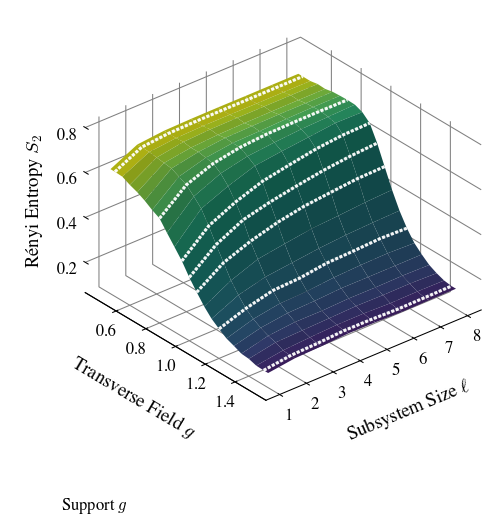

In [66]:
# =========================
# Cell - Entropy surface (3D only)  [viridis surface + cut lines]
# (manual crop viewport + visible crop box + optional axes scaling)
# =========================
from matplotlib.transforms import Bbox
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib import ticker
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

# Assumes external variables exist:
# df_res, h_dense, l_values, Z_s2, support_h_keys, ref_style, SB_COLORBLIND
# SINGLE_COL_WIDTH, DOUBLE_COL_WIDTH, DPI

SAVE_FIG = True
FILENAME = "tfim_4x4_entropy_3d_hero.svg"
COLUMN_MODE = "single"

# ==========================================================
# FONT SIZES (separate knobs)
# ==========================================================
TEXT_SIZE = 9
TICK_LABEL_SIZE = 8
LEGEND_SIZE = 8
PANE_LABEL_SIZE = 12

# ==========================================================
# 3D KNOBS
# ==========================================================
SHIFT_3D_X = -0.02

BOX_ASPECT_X = 1.0
BOX_ASPECT_Y = 1.0
BOX_ASPECT_Z = 0.7

XTICK_PAD = -3
YTICK_PAD = -3
ZTICK_PAD = -3

X_LABEL_SPACE = 0.0
Y_LABEL_SPACE = 0.0
X_LABELPAD = 0
Y_LABELPAD = 0

ZLABEL_X = -0.04
ZLABEL_Y = 0.55
ZLABEL_ROT = 90

VIEW_ELEV = 30
VIEW_AZIM = -40

# ==========================================================
# CUT LINE STYLE (WHITE DOTS ONLY)
# ==========================================================
CUT_DOT_LW     = 1.5
CUT_DOT_ALPHA  = 0.95
CUT_DOT_DASHES = (1.0, 0.5)   # (on, off) in points

# --- tiny surface tail in h-direction (constant extension) ---
H_SURFACE_TAIL = 0.03

# ==========================================================
# FIGURE SIZE
# ==========================================================
FIG_HEIGHT_RATIO_3D = 1.15
width  = SINGLE_COL_WIDTH if COLUMN_MODE == "single" else DOUBLE_COL_WIDTH
height = width * FIG_HEIGHT_RATIO_3D

FIELD_SYMBOL = "g"

def _apply_3d_label_spacing(ax, x_space, y_space, x_pad, y_pad):
    ax.xaxis._axinfo["label"]["space_factor"] = x_space
    ax.yaxis._axinfo["label"]["space_factor"] = y_space
    ax.xaxis.labelpad = x_pad
    ax.yaxis.labelpad = y_pad

# ==========================================================
# OPTIONAL: scale the *axes box*
# ==========================================================
AXES_SCALE_X = 1.00
AXES_SCALE_Y = 1.00
AXES_SHIFT_X = 0.00
AXES_SHIFT_Y = 0.00

# ==========================================================
# MANUAL CROP VIEWPORT
# ==========================================================
APPLY_CROP = True
SHOW_CROP_BOX = False

# crop amounts as fractions of the *figure*
CROP_LEFT_FRAC   = -0.05
CROP_RIGHT_FRAC  = 0.04
CROP_BOTTOM_FRAC = -0.2
CROP_TOP_FRAC    = 0.14

# shift + scale the crop box itself
CROP_SHIFT_X = 0.00
CROP_SHIFT_Y = 0.00
CROP_SCALE_X = 1.00
CROP_SCALE_Y = 1.00

CROP_PAD_INCH = 0.00

def _make_crop_bbox(fig):
    fw, fh = fig.get_size_inches()

    x0 = CROP_LEFT_FRAC
    y0 = CROP_BOTTOM_FRAC
    w0 = 1.0 - CROP_LEFT_FRAC - CROP_RIGHT_FRAC
    h0 = 1.0 - CROP_BOTTOM_FRAC - CROP_TOP_FRAC

    cx = x0 + 0.5 * w0 + CROP_SHIFT_X
    cy = y0 + 0.5 * h0 + CROP_SHIFT_Y
    w  = w0 * CROP_SCALE_X
    h  = h0 * CROP_SCALE_Y

    x0n = cx - 0.5 * w
    y0n = cy - 0.5 * h
    x1n = cx + 0.5 * w
    y1n = cy + 0.5 * h

    x0n = max(0.0, min(1.0, x0n))
    y0n = max(0.0, min(1.0, y0n))
    x1n = max(0.0, min(1.0, x1n))
    y1n = max(0.0, min(1.0, y1n))
    if x1n <= x0n: x1n = min(1.0, x0n + 1e-3)
    if y1n <= y0n: y1n = min(1.0, y0n + 1e-3)

    bbox_in = Bbox.from_extents(x0n * fw, y0n * fh, x1n * fw, y1n * fh)
    if CROP_PAD_INCH > 0:
        bbox_in = bbox_in.padded(CROP_PAD_INCH)

    return bbox_in, (x0n, y0n, x1n - x0n, y1n - y0n)

with plt.rc_context({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "savefig.transparent": False,
    "axes.labelsize": TEXT_SIZE,
    "xtick.labelsize": TICK_LABEL_SIZE,
    "ytick.labelsize": TICK_LABEL_SIZE,
    "legend.fontsize": LEGEND_SIZE,
}):
    fig = plt.figure(figsize=(width, height), dpi=DPI)
    fig.patch.set_alpha(1.0)
    fig.subplots_adjust(left=0.16, right=0.98, top=0.98, bottom=0.08)

    ax3d = fig.add_subplot(111, projection="3d")
    ax3d.set_proj_type("ortho")

    pos = ax3d.get_position()
    ax3d.set_position([pos.x0 + SHIFT_3D_X, pos.y0, pos.width, pos.height])

    # optional: scale the axes box
    if (AXES_SCALE_X != 1.0) or (AXES_SCALE_Y != 1.0) or (AXES_SHIFT_X != 0.0) or (AXES_SHIFT_Y != 0.0):
        pos = ax3d.get_position()
        cx, cy = pos.x0 + pos.width/2, pos.y0 + pos.height/2
        nw, nh = pos.width * AXES_SCALE_X, pos.height * AXES_SCALE_Y
        nx0 = cx - nw/2 + AXES_SHIFT_X
        ny0 = cy - nh/2 + AXES_SHIFT_Y
        ax3d.set_position([nx0, ny0, nw, nh])

    ax3d.zaxis._axinfo["juggled"] = (1, 0, 2)

    ax3d.minorticks_off()
    ax3d.xaxis.set_minor_locator(ticker.NullLocator())
    ax3d.yaxis.set_minor_locator(ticker.NullLocator())
    ax3d.zaxis.set_minor_locator(ticker.NullLocator())

    ax3d.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax3d.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax3d.zaxis.set_major_locator(ticker.MultipleLocator(0.2))

    ax3d.set_box_aspect((BOX_ASPECT_X, BOX_ASPECT_Y, BOX_ASPECT_Z))

    grid_style = {"color": "gray", "linewidth": 0.5, "alpha": 0.3}
    for axis in (ax3d.xaxis, ax3d.yaxis, ax3d.zaxis):
        axis._axinfo["grid"].update(grid_style)
        axis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # ==========================================================
    # SURFACE + TAIL
    # ==========================================================
    h_min, h_max = float(h_dense.min()), float(h_dense.max())

    # extend x-grid, but replicate edge Z columns (so geometry continues smoothly)
    h_dense_ext = np.concatenate([[h_min - H_SURFACE_TAIL], h_dense, [h_max + H_SURFACE_TAIL]])
    Z_s2_ext = np.concatenate([Z_s2[:, [0]], Z_s2, Z_s2[:, [-1]]], axis=1)
    X_h_ext, Y_l_ext = np.meshgrid(h_dense_ext, l_values)

    cmap_surface = plt.get_cmap("viridis")

    # IMPORTANT: keep colormap normalization on ORIGINAL range,
    # and clip the tail to the edge colors (prevents “blue padding”).
    norm_h = mcolors.Normalize(vmin=h_min, vmax=h_max)
    X_for_color = np.clip(X_h_ext, h_min, h_max)

    t = norm_h(X_for_color)
    t = 1.0 - t
    t = 0.10 + 0.85 * t
    surface_colors = cmap_surface(t)

    ax3d.plot_surface(
        X_h_ext, Y_l_ext, Z_s2_ext,
        facecolors=surface_colors,
        rstride=1, cstride=1,
        shade=True, linewidth=0, alpha=1.0,
        antialiased=True
    )

    ax3d.set_zlim(np.min(Z_s2) - 0.05, np.max(Z_s2) + 0.1)

    ax3d.set_xlabel(rf"Transverse Field ${FIELD_SYMBOL}$", fontsize=TEXT_SIZE)
    ax3d.set_ylabel(r"Subsystem Size $\ell$", fontsize=TEXT_SIZE)

    ax3d.set_zlabel("")
    zlab = ax3d.text2D(
        ZLABEL_X, ZLABEL_Y, r"Rényi Entropy $S_2$",
        transform=ax3d.transAxes,
        rotation=ZLABEL_ROT, va="center", ha="right",
        fontsize=TEXT_SIZE,
        clip_on=False
    )

    ax3d.view_init(elev=VIEW_ELEV, azim=VIEW_AZIM)
    _apply_3d_label_spacing(ax3d, X_LABEL_SPACE, Y_LABEL_SPACE, X_LABELPAD, Y_LABELPAD)

    # ==========================================================
    # CUT LINES (WHITE DOTS ONLY, NO UNDERLAY)
    # ==========================================================
    h_sorted = sorted([float(h) for h in support_h_keys])

    _cut_dot = dict(ref_style)
    _cut_dot.pop("label", None)
    _cut_dot.pop("alpha", None)
    _cut_dot["linestyle"] = "-"          # use explicit dashes for consistent dot pattern
    _cut_dot["dashes"]    = CUT_DOT_DASHES
    _cut_dot["linewidth"] = CUT_DOT_LW
    _cut_dot["alpha"]     = CUT_DOT_ALPHA
    _cut_dot["color"]     = "white"

    # tiny lift to avoid z-fighting with the surface in SVG renderers
    Z_LIFT = 1e-4

    for h0 in h_sorted:
        subset = df_res[df_res["h"] == h0].sort_values("l")
        ell = subset["l"].values.astype(int)
        s2_vals = subset["s2"].values.astype(float) + Z_LIFT
        xline = np.full_like(ell, h0, dtype=float)

        ax3d.plot(
            xline, ell, s2_vals,
            **_cut_dot,
            zorder=20,
            solid_capstyle="round",
            solid_joinstyle="round",
        )

    # tick padding AFTER draw
    fig.canvas.draw()
    for tck in ax3d.xaxis.get_major_ticks(): tck.set_pad(XTICK_PAD)
    for tck in ax3d.yaxis.get_major_ticks(): tck.set_pad(YTICK_PAD)
    for tck in ax3d.zaxis.get_major_ticks(): tck.set_pad(ZTICK_PAD)

    for lab in ax3d.get_xticklabels() + ax3d.get_yticklabels() + ax3d.get_zticklabels():
        lab.set_clip_on(False)
        lab.set_fontsize(TICK_LABEL_SIZE)

    fig.canvas.draw()

    # legend handle (matches the cut lines)
    support_handle = Line2D(
        [0], [0],
        linestyle="-",
        dashes=CUT_DOT_DASHES,
        linewidth=CUT_DOT_LW,
        color="white",
        alpha=CUT_DOT_ALPHA,
    )

    fig.legend(
        handles=[support_handle],
        labels=[r"Support $g$"],
        loc="lower left",
        bbox_to_anchor=(0.02, 0.02),
        frameon=False,
        handlelength=2.2,
        handletextpad=0.6,
    )

    # ---- draw crop box (debug) ----
    crop_bbox_in, (rx, ry, rw, rh) = _make_crop_bbox(fig)
    if SHOW_CROP_BOX:
        fig.add_artist(Rectangle(
            (rx, ry), rw, rh,
            transform=fig.transFigure,
            fill=False,
            linewidth=1.0,
            linestyle=(0, (3, 3)),
            edgecolor="crimson",
            alpha=0.85,
            zorder=9999,
        ))

    if SAVE_FIG:
        if APPLY_CROP:
            fig.savefig(
                FILENAME,
                bbox_inches=crop_bbox_in,
                bbox_extra_artists=[zlab],
                transparent=False,
                facecolor="white",
                edgecolor="none",
            )
        else:
            fig.savefig(
                FILENAME,
                transparent=False,
                facecolor="white",
                edgecolor="none",
            )
        print(f"Saved: {FILENAME}")

    plt.show()


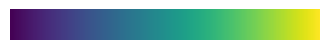

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# continuous gradient (many samples), displayed as a 10x1 bar
W, H = 1000, 1
grad = np.linspace(0, 1, W)[None, :]  # shape (1, W)

fig, ax = plt.subplots(figsize=(2.0, 0.2), dpi=200)
ax.imshow(grad, cmap="viridis", aspect="auto", interpolation="bilinear")
ax.set_axis_off()

plt.savefig("viridis_bar.svg", format="svg", bbox_inches="tight", pad_inches=0, transparent=True)
plt.show()

# save as
